# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [2]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
mnist = fetch_mldata('MNIST original', data_home='~/datasets/mnist')
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print 'data shape: ', X.shape
print 'label shape:', Y.shape

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

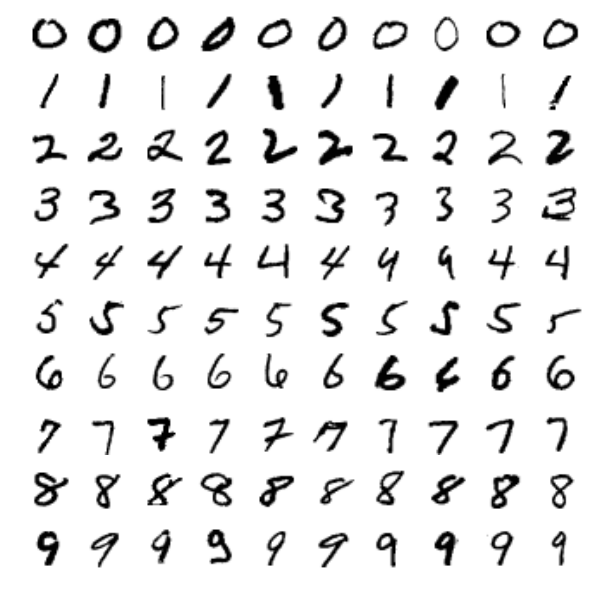

In [3]:
def P1(num_examples=10):

### STUDENT START ###
    
    #define a function to get an ordered list of indicies where a particular label equals a value
    def get_indicies(number, n_e=num_examples):
        indicies = []
        num_examples = 0
        for idx, val in enumerate(mini_train_labels):
            if val == number:
                indicies.append(idx)
                num_examples = num_examples + 1
                if n_e == num_examples:
                    break
        return(indicies)
    
    # use a list comprehension to call the function for each digit
    all_examples = [get_indicies(x) for x in range(0,10)]
    
    # flatten our list of lists produced above
    flattened = [item for sublist in all_examples for item in sublist]

    #set up our plot's figure size
    plt.figure(figsize=(10, 10))
    
    #enumerate through the flattened list and plot examples 
    for i, x in enumerate(flattened):
        ax = plt.subplot(10,num_examples,i+1)
        ax.imshow(mini_train_data[x].reshape(28,28),  cmap=plt.cm.binary)
        ax.axis('off')
        
### STUDENT END ###
P1(10)

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [4]:
def P2(k_values):

### STUDENT START ###
    results = []

    for idx, val in enumerate(k_values):
        clf = KNeighborsClassifier(n_neighbors=val)
        clf.fit(mini_train_data, mini_train_labels)
        preds = clf.predict(dev_data)
        num_corr = np.where(preds==dev_labels, 1, 0).sum()
        print "Neighbors: %d, Accuracy: %3f, Num Correct: %d" % (val, num_corr/float(len(dev_data)), num_corr)
        
        results.append([val, num_corr/float(len(dev_data)), num_corr])
        
        if val == 1:
            print classification_report(dev_labels, preds)
### STUDENT END ###

k_values = [1,3,5,7,9]
P2(k_values)

Neighbors: 1, Accuracy: 0.888000, Num Correct: 888
             precision    recall  f1-score   support

        0.0       0.91      0.98      0.94        99
        1.0       0.89      1.00      0.94       105
        2.0       0.99      0.79      0.88       102
        3.0       0.77      0.87      0.82        86
        4.0       0.89      0.82      0.85       104
        5.0       0.93      0.84      0.88        91
        6.0       0.94      0.96      0.95        98
        7.0       0.89      0.92      0.90       113
        8.0       0.94      0.88      0.91        96
        9.0       0.78      0.82      0.80       106

avg / total       0.89      0.89      0.89      1000

Neighbors: 3, Accuracy: 0.878000, Num Correct: 878
Neighbors: 5, Accuracy: 0.869000, Num Correct: 869
Neighbors: 7, Accuracy: 0.865000, Num Correct: 865
Neighbors: 9, Accuracy: 0.863000, Num Correct: 863


ANSWER: As K increases, the classifier seesm to decrease in accuracy.

For k == 1, we see that the digit 9 is the most difficult digit, with the lowest f1-score (0.80). F1 represent the harmonic mean of precision and recall. 

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [8]:
def P3(train_sizes, accuracies):

### STUDENT START ###

    for val in train_sizes:
        clf = KNeighborsClassifier(n_neighbors=1)
        time_start = time.time()
        clf.fit(train_data[:val], train_labels[:val])
        preds = clf.predict(dev_data)
        fit_time = time.time() - time_start
        num_corr = np.where(preds==dev_labels, 1, 0).sum()
        print "Train Size %i, Time (s): %.3g, Neighbors: %i, Accuracy: %.3g, Num Correct: %d" \
               % (val, fit_time, 1, round(num_corr/float(len(dev_data)),2), round(num_corr,2))
        
        accuracies.append([fit_time, val, num_corr/float(len(dev_data)), num_corr])
    return(accuracies)

### STUDENT END ###

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = []

P3(train_sizes, accuracies)

Train Size 100, Time (s): 0.0845, Neighbors: 1, Accuracy: 0.72, Num Correct: 720
Train Size 200, Time (s): 0.171, Neighbors: 1, Accuracy: 0.79, Num Correct: 786
Train Size 400, Time (s): 0.346, Neighbors: 1, Accuracy: 0.84, Num Correct: 841
Train Size 800, Time (s): 0.727, Neighbors: 1, Accuracy: 0.88, Num Correct: 884
Train Size 1600, Time (s): 1.47, Neighbors: 1, Accuracy: 0.9, Num Correct: 902
Train Size 3200, Time (s): 3.08, Neighbors: 1, Accuracy: 0.93, Num Correct: 926
Train Size 6400, Time (s): 5.9, Neighbors: 1, Accuracy: 0.94, Num Correct: 937
Train Size 12800, Time (s): 12.3, Neighbors: 1, Accuracy: 0.96, Num Correct: 959
Train Size 25000, Time (s): 29.1, Neighbors: 1, Accuracy: 0.97, Num Correct: 970


[[0.08450007438659668, 100, 0.71999999999999997, 720],
 [0.17051219940185547, 200, 0.78600000000000003, 786],
 [0.34631896018981934, 400, 0.84099999999999997, 841],
 [0.7274069786071777, 800, 0.88400000000000001, 884],
 [1.4650068283081055, 1600, 0.90200000000000002, 902],
 [3.077519178390503, 3200, 0.92600000000000005, 926],
 [5.897974967956543, 6400, 0.93700000000000006, 937],
 [12.261253118515015, 12800, 0.95899999999999996, 959],
 [29.0814208984375, 25000, 0.96999999999999997, 970]]

(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

Coefficients: 0.00000667
Residual sum of squares: 0.003475
R^2 score: 0.443061
Predicted accuracy when N = 60,000: [ 1.24307226]


Coefficients: 0.09732856
Residual sum of squares: 0.000543
R^2 score: 0.912944
Predicted accuracy when N = 60,000: [ 1.03386514]




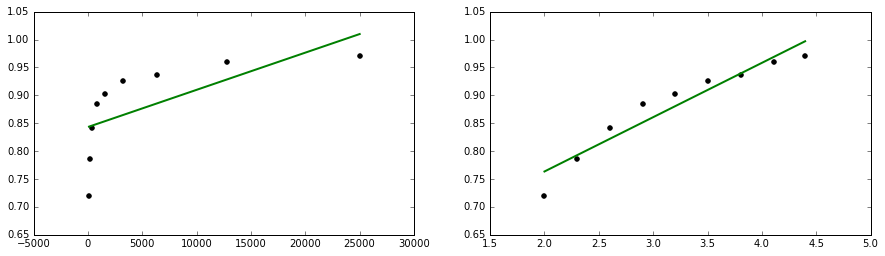

In [9]:
def P4():

    ### STUDENT START ###
    train = np.array(train_sizes)
    #create training data
    x_size = train.reshape(-1,1)
    #create test array
    n = np.array([60000]).reshape(-1,1)

    #pull out accuracies from list from p above
    extracted_accuracies = [accuracies[x][2] for x in range(0,len(accuracies))]

    #create target variable
    y_accuracies = np.array(extracted_accuracies)

    # Create linear regression object
    regr = LinearRegression()

    # Train the model using the training sets
    regr.fit(x_size, y_accuracies)

    def output(x, y, n=0):
        #create a regression object
        model = LinearRegression()
        #train the model
        model.fit(x,y)
        # Output coefficients
        print 'Coefficients: %.8f' % model.coef_
        # The mean square error
        print "Residual sum of squares: %.6f" % np.mean((model.predict(x) - y) ** 2)
        # Explained variance score: 1 is a perfect prediction
        print 'R^2 score: %.6f' % model.score(x, y)
        print 'Predicted accuracy when N = 60,000:', model.predict(n)
        print '\n'
        plt.scatter(x, y,  color='black')
        plt.plot(x, model.predict(x), color = 'green', linewidth=2)
    
    #set up plots for first call
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)

    #normal input data
    output(x_size, y_accuracies, n)

    #set up plots for second call
    plt.subplot(1, 2, 2)
    #log transform x_size to handle non-linearities
    output(np.log10(x_size), y_accuracies, np.log10(n))

### STUDENT END ###
P4()

ANSWER: For N = 60000, the linear model predicts accuracy of 1.24 which is unreasonable because we can't have an accuracy above 1. 

This can be improved by applying a log transformation to the data. When we do this, we observe a predicted accuracy of 1.03 which is still impossible but as the graph shows, the regression line fits the transformed data much better. 

Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

[[ 97   0   0   0   0   0   2   0   0   0]
 [  0 105   0   0   0   0   0   0   0   0]
 [  4   4  81   4   0   0   0   4   3   2]
 [  1   0   0  75   0   3   0   3   1   3]
 [  0   2   0   0  85   0   3   0   0  14]
 [  2   0   0   9   0  76   0   1   1   2]
 [  1   1   1   0   1   0  94   0   0   0]
 [  1   4   0   1   1   0   0 104   0   2]
 [  0   2   0   5   0   2   1   0  84   2]
 [  1   0   0   3   9   1   0   5   0  87]]


Examples of mismatched digits for the following tuple:  [(14, 4, 9)]


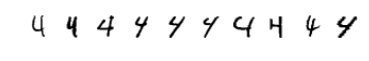

In [44]:
def P5():

### STUDENT START ###

    #instantiate example of class  
    model = KNeighborsClassifier(n_neighbors=1)

    #fit model with training data
    model.fit(mini_train_data, mini_train_labels)
    #print 'KNN score: %f' % model.fit(mini_train_data, mini_train_labels).score(dev_data, dev_labels)

    #store preo
    predicted = model.predict(dev_data)

    # confusion matrix
    cm = confusion_matrix(dev_labels, predicted, labels=model.classes_)
    print cm

    #define a simple variable to use to find mismatched examples
    r = range(0,len(cm))    
    def identify_mismatches(i,j,cm):
        if i != j:
            if cm[i][j] > 0:
                return(cm[i][j],i,j)

    #iterate through each cell of the cm and identify mismatched examples
    #return list of tuples
    l = [identify_mismatches(i,j,cm) for i in r for j in r]

    #filter tuple examples that equal None
    tups = [x for x in l if x is not None]

    #reassign variable as the top tuple that mismatched
    tups = sorted(tups,key=lambda tup: tup[0], reverse=True)[:1]

    #identify examples matching the top pair of mismatched digits
    data_to_render = dev_data[(dev_labels == tups[0][1]) & (predicted == tups[0][2])][:10]

    #reshape
    data_to_render_reshape = np.reshape(data_to_render, (len(data_to_render), 28,-1))

    #enumerate through the flattened list and plot examples 
    print "\n"
    print "Examples of mismatched digits for the following tuple: ", tups
    for x in range(0, len(data_to_render)): 
        plt.subplot(1,len(data_to_render),x+1), plt.imshow(data_to_render_reshape[x], cmap=plt.cm.binary)
        plt.axis('off')

### STUDENT END ###

P5()

(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

In [296]:
def P6():

    ### STUDENT START ###

    #first need to define a function to blur according to the above instructions
    #this took some time to think through... and is just a box blur (which can approximate gaussian)
    def blur(array, neighbors=8):
        num_neighbors = neighbors / 2 

        def element_blur(array, index, num_neighbors):
            left = array[:index][-num_neighbor:]
            right= array[index+1:num_neighbor+index+1]
            c_array = np.concatenate((left,right),0)
            return np.average(c_array)

        return np.asarray([element_blur(array, index, num_neighbor) for index in range(len(array))])

    #make a copy of the mini_train_data
    blurred_mini_train_data = mini_train_data.copy()

    #there is probably a way to vectorize this... 
    for idx, digit in enumerate(mini_train_data):
        #update each point with a blurred version
        blurred_mini_train_data[idx] = blur(digit)

    #make a copy of the mini_train_data
    blurred_dev_data = dev_data.copy()

    #there is probably a way to vectorize this... 
    for idx, digit in enumerate(dev_data):
        #update each point with a blurred version
        blurred_dev_data[idx] = blur(digit)


    #instantiate example of class  
    model = KNeighborsClassifier(n_neighbors=1)
    #fit model with training data
    model.fit(blurred_mini_train_data, mini_train_labels)
    #store predicted values
    predicted = model.predict(dev_data)
    num_corr = np.where(predicted==dev_labels, 1, 0).sum()
    print "Training Data Blurred: Accuracy: %.3g, Num Correct: %d" \
        % (round(num_corr/float(len(dev_data)),2), round(num_corr,2))

    #instantiate example of class  
    model = KNeighborsClassifier(n_neighbors=1)
    #fit model with training data
    model.fit(mini_train_data, mini_train_labels)
    #store predicted values
    predicted = model.predict(blurred_dev_data)
    num_corr = np.where(predicted==dev_labels, 1, 0).sum()
    print "Dev Data Blurred: Accuracy: %.3g, Num Correct: %d" \
        % (round(num_corr/float(len(dev_data)),2), round(num_corr,2))

    #instantiate example of class  
    model = KNeighborsClassifier(n_neighbors=1)
    #fit model with training data
    model.fit(blurred_mini_train_data, mini_train_labels)
    #store predicted values
    predicted = model.predict(blurred_dev_data)
    num_corr = np.where(predicted==dev_labels, 1, 0).sum()
    print "Both sets of Data Blurred: Accuracy: %.3g, Num Correct: %d" \
        % (round(num_corr/float(len(dev_data)),2), round(num_corr,2))

    ### STUDENT END ###

P6()


Training Data Blurred: Accuracy: 0.67, Num Correct: 666
Dev Data Blurred: Accuracy: 0.53, Num Correct: 530
Both sets of Data Blurred: Accuracy: 0.85, Num Correct: 854


ANSWER:

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

In [112]:
def P7():

### STUDENT START ###

    #didn't know how to best set binarize threshold argument
    #perform search through threshold values increasing with below step function

    top_binarize, max_score = 0,0
    for x in np.arange(0,1,.01):
        binaryNB = BernoulliNB(binarize=x)
        binaryNB.fit(mini_train_data, mini_train_labels)
        cur_score = binaryNB.score(dev_data, dev_labels)
        if cur_score > max_score:
            max_score, top_binarize = cur_score, x

    #print top value for binarize argument and resulting score
    print 'For binarize val: %2.4f, BernoulliNB accuracy: %2.4f' % (top_binarize, max_score)

    #mapping pixels to 0,1,2
    def mapping(x, threshold):
        if x>=threshold:
            return 2
        elif x>0 and x<threshold:
            return 1
        else:
            return 0

    #vectorize the function
    mapping_vectorized = np.vectorize(mapping)

    top_map, max_score_multi = 0,0
    for x in np.arange(0,1,.01):
        #apply function to datasets
        mapped_train_data, mapped_dev_data = mapping_vectorized(mini_train_data,x), mapping_vectorized(dev_data,x)
        mappedNB = MultinomialNB()
        mappedNB.fit(mapped_train_data, mini_train_labels)
        cur_score = mappedNB.score(mapped_dev_data, dev_labels)
        if cur_score > max_score_multi:
            max_score_multi, top_map = cur_score, x

    print '\nFor map threshold val: %2.4f, MultinomialNB accuracy: %2.4f' % (top_map, max_score_multi)

### STUDENT END ###

P7()

For binarize val: 0.3700, BernoulliNB accuracy: 0.8230

 For map threshold val: 0.2200, MultinomialNB accuracy: 0.7980


ANSWER: The multi-class version, even with a thorough search for the best threshold value to use in the mapping function, does not improve the results. Essentially, I interpret this to mean that having fewer features gives us more classification power in this context. 

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [129]:
def P8(alphas):

    ### STUDENT START ###
    
    #match the binarize threshold value determined to be the best from P7
    #instantiate the class
    NBGridSearch = GridSearchCV(BernoulliNB(binarize=.37), alphas, scoring='accuracy')

    #fit on training data
    NBGridSearch.fit(mini_train_data, mini_train_labels)

    # Report out on the accuracies of the gridsearch
    for params, mean_score, scores in NBGridSearch.grid_scores_:
        print "%0.4f (+/-%0.04f) for %r" % (mean_score, scores.std() / 2, params)

    ### STUDENT END ###
    
alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = P8(alphas)

0.0920 (+/-0.0004) for {'alpha': 0.0}
0.8200 (+/-0.0116) for {'alpha': 0.0001}
0.8200 (+/-0.0093) for {'alpha': 0.001}
0.8210 (+/-0.0090) for {'alpha': 0.01}
0.8190 (+/-0.0092) for {'alpha': 0.1}
0.8090 (+/-0.0059) for {'alpha': 0.5}
0.8050 (+/-0.0052) for {'alpha': 1.0}
0.7970 (+/-0.0042) for {'alpha': 2.0}
0.7350 (+/-0.0118) for {'alpha': 10.0}


ANSWER: Using GridSearch I found the best alpha value to = .01 and yield an accuracy of .821 (82.1%). The accuracy is very low when alpha = 0, only 9%. This does seem to make sense, however - the naive bayes model multiplies together probabilities of (classification | feature) based on the observed training data. When we don't smooth, if a digit has a pixel that was never associated with that digit in training (P = 0%), naive bayes assumes that the classification probability is 0%

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

In [224]:
def P9():

    ### STUDENT END ###
    
    #simple gaussian fit
    model = GaussianNB()
    model.fit(mini_train_data,mini_train_labels)
    cur_score = model.score(dev_data, dev_labels)
    print 'GaussianNB accuracy: %2.4f' % (cur_score)

    #adding random noise drawn from a gaussian distribution

    def add_noise(array, mean=.5, std=.2):
        return (array + np.random.normal(mean,std,array.shape))

    noisy_model = GaussianNB()
    noisy_model.fit(add_noise(mini_train_data), mini_train_labels)
    cur_score = noisy_model.score(add_noise(dev_data), dev_labels)

    print 'Noisy GaussianNB accuracy: %2.4f' % (cur_score)

    #try independently modify theta (mean of each feature per class)
    top_theta, max_score = 0,0
    for x in np.arange(0,1,.05):
        model = GaussianNB()
        model.fit(mini_train_data,mini_train_labels)
        model.theta_ = model.theta_ + x
        cur_score = model.score(dev_data, dev_labels)
        if cur_score > max_score:
            max_score, top_theta = cur_score, x
    print 'Best Theta: %2.4f, GaussianNB accuracy: %2.4f' % (top_theta, max_score)

    #try independently modify sigma (variance of each feature per class)
    top_sigma, max_score = 0,0
    for x in np.arange(0,1,.001):
        model = GaussianNB()
        model.fit(mini_train_data,mini_train_labels)
        model.sigma_ = model.sigma_ + x
        cur_score = model.score(dev_data, dev_labels)
        if cur_score > max_score:
            max_score, top_sigma = cur_score, x
    print 'Best Sigma: %2.4f, GaussianNB accuracy: %2.4f' % (top_sigma, max_score)

    #iteratively modify theta and simga in concert (limit range of each given large number of required iterations)
    top_sigma, top_theta, max_score = 0,0,0
    for x in np.arange(0,.2,.001):
        for j in np.arange(0,1,.05):
            model = GaussianNB()
            model.fit(mini_train_data,mini_train_labels)
            model.sigma_ = model.sigma_ + x
            model.theta_ = model.theta_ + j
            cur_score = model.score(dev_data, dev_labels)
            if cur_score > max_score:
                max_score, top_sigma, top_theta = cur_score, x, j

    print 'Modified Together -  Best Theta: %2.4f, Best Sigma: %2.4f, GaussianNB accuracy: %2.4f' % \
        (top_theta, top_sigma, max_score)

gnb = P9()

GaussianNB accuracy: 0.6210
Noisy GaussianNB accuracy: 0.8180
Best Theta: 0.0000, GaussianNB accuracy: 0.6210
Best Sigma: 0.0150, GaussianNB accuracy: 0.7930
Modified Together -  Best Theta: 0.1500, Best Sigma: 0.0090, GaussianNB accuracy: 0.8220


ANSWER: A large number of 0-valued features skew the model and result in poor accuracy. Adding gaussian noise with a simple transformation works to cheaply improve the classifiers accuracy. Modifying Sigma (variance) iteratively by it's lonesome tends also improve our classifier's accuracy. Modifying Theta iteratively by it's lonesome tends to decrease our classifier's accuracy. By modifying them in concert, similar to what is achieved with our random noise function, we're able to improve the classifier's accuracy the most.

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

BernoulliNB accuracy: 0.82


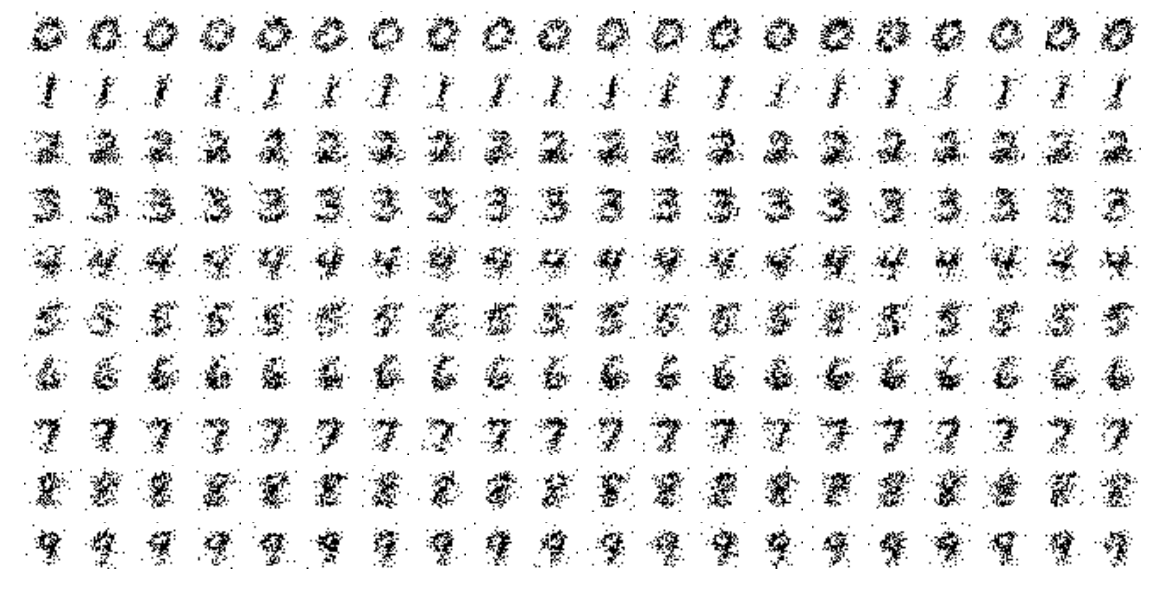

In [306]:
def P10(num_examples):

### STUDENT START ###

    #instantiate model with threshold set
    binaryNB = BernoulliNB(binarize=.37)
    #fit a model on the data
    binaryNB.fit(mini_train_data, mini_train_labels)
    score = binaryNB.score(dev_data, dev_labels)

    print 'BernoulliNB accuracy: %3.2f' % score

    # Get log probabilities for each feature (and exponentiate)
    probs = np.exp(binaryNB.feature_log_prob_)

    # Render examples using the probability
    plt.figure(figsize=(num_examples, 10))
    for digit in range (0,10):
        for example in range(0,num_examples):
            rand = np.random.rand(784)
            # Determine what pixels to turn on
            generate_num = np.array(rand <= probs[digit], dtype=int).reshape(28,-1)
            plt.subplot(10,num_examples,(digit * num_examples) + example + 1)
            plt.imshow(generate_num, cmap=plt.cm.binary)
            plt.axis('off')

### STUDENT END ###

P10(20)


ANSWER: Interestingly, the digits end up being recognizable! Certainly not as crisp as when the pixels aren't randomly selected but quite readable nonetheless

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [ ]:
#def P11(buckets, correct, total):
    
### STUDENT START ###


                
### STUDENT END ###

#buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
#correct = [0 for i in buckets]
#total = [0 for i in buckets]

#P11(buckets, correct, total)

#for i in range(len(buckets)):
#    accuracy = 0.0
#    if (total[i] > 0): accuracy = correct[i] / total[i]
#    print 'p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy)

ANSWER:

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [ ]:
#def P12():

### STUDENT START ###


### STUDENT END ###

#P12()